# A2.5 Multilayer Neural Networks for Nonlinear Regression


Sebastian Infantes

## Summary

In this assignment you will 
* make some modifications to the supplied neural network implementation, 
* define a function that partitions data into training, validation and test sets,
* apply it to a data set, 
* define a function that runs experiments with a variety of parameter values, 
* describe your observations of these results.

## Optimizers

First, we need a class that includes our optimization algorithms, `sgd` and `adam`.  The following code cell implements `sgd`.  You must complete the implementation of `adam`, following its implementation in the lecture notes.

Notice that `all_weights` is updated in place by these optimization algorithms.  The new values of `all_weights` are not returned from these functions, because the code that calls these functions allocates the memory for `all_weights` and keeps the reference to it so has direct access to the new values.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Optimizers():

    def __init__(self, all_weights):
        '''all_weights is a vector of all of a neural networks weights concatenated into a one-dimensional vector'''
        
        self.all_weights = all_weights

        # The following initializations are only used by adam.
        # Only initializing mt, vt, beta1t and beta2t here allows multiple calls to adam to handle training
        # with multiple subsets (batches) of training data.
        self.mt = np.zeros_like(all_weights)
        self.vt = np.zeros_like(all_weights)
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.beta1t = 1  # was self.beta1
        self.beta2t = 1  # was self.beta2

        
    def sgd(self, error_f, gradient_f, fargs=[], n_epochs=100, learning_rate=0.001, error_convert_f=None):
        '''
error_f: function that requires X and T as arguments (given in fargs) and returns mean squared error.
gradient_f: function that requires X and T as arguments (in fargs) and returns gradient of mean squared error
            with respect to each weight.
error_convert_f: function that converts the standardized error from error_f to original T units.
        '''

        error_trace = []
        epochs_per_print = n_epochs // 10

        for epoch in range(n_epochs):

            error = error_f(*fargs)
            grad = gradient_f(*fargs)

            # Update all weights using -= to modify their values in-place.
            self.all_weights -= learning_rate * grad

            if error_convert_f:
                error = error_convert_f(error)
            error_trace.append(error)

            if (epoch + 1) % max(1, epochs_per_print) == 0:
                print(f'sgd: Epoch {epoch+1:d} Error={error:.5f}')

        return error_trace

    def adam(self, error_f, gradient_f, fargs=[], n_epochs=100, learning_rate=0.001, error_convert_f=None):
        '''
error_f: function that requires X and T as arguments (given in fargs) and returns mean squared error.
gradient_f: function that requires X and T as arguments (in fargs) and returns gradient of mean squared error
            with respect to each weight.
error_convert_f: function that converts the standardized error from error_f to original T units.
        '''
        
        # adam = Adaptive Moment Estimation

        alpha = learning_rate  # learning rate called alpha in original paper on adam
        epsilon = 1e-8
        error_trace = []
        epochs_per_print = n_epochs // 10

        for epoch in range(n_epochs):

            error = error_f(*fargs)
            grad = gradient_f(*fargs)

            # Finish Adam implementation here by updating
            #   self.mt
            #   self.vt
            #   self.beta1t
            #   self.beta2t
            # and updating values of self.all_weights
            
            # mt = beta1 * mt + (1 - beta1) * gradE_W
            gradE_W = learning_rate * grad
            self.mt = self.beta1 * self.mt + (1 - self.beta1) * (gradE_W)
            
            # vt = beta2 * vt + (1 - beta2) * np.square(gradE_W)
            self.vt = self.beta2 * self.vt + (1 - self.beta2) * np.square(gradE_W)
            
            # beta1t *= beta1
            self.beta1t *= self.beta1
            
            # beta2t *= beta2
            self.beta2t *= self.beta2
            
            # mhat = mt / (1 - beta1)
            mhat = self.mt / (1 - self.beta1t)
            
            # vhat = vt / (1 - beta2)
            vhat = self.vt / (1 - self.beta2t)
            
            # w -= rho * mhat / (np.sqrt(vhat) + epsilon)
            # rho = learning rate?
            self.all_weights -= learning_rate * mhat / (np.sqrt(vhat) + epsilon)
        

            if error_convert_f:
                error = error_convert_f(error)
            error_trace.append(error)

#             if (epoch + 1) % max(1, epochs_per_print) == 0:
#                 print(f'Adam: Epoch {epoch+1:d} Error={error:.5f}')

        return error_trace

Test `Optimizers` using the function `test_optimizers`.  You should get the same results shown below.

In [3]:
def test_optimizers():

    def parabola(wmin):
        return ((w - wmin) ** 2)[0]

    def parabola_gradient(wmin):
        return 2 * (w - wmin)

    w = np.array([0.0])
    optimizer = Optimizers(w)

    wmin = 5
    optimizer.sgd(parabola, parabola_gradient, [wmin], n_epochs=100, learning_rate=0.1)
    print(f'sgd: Minimum of parabola is at {wmin}. Value found is {w}')

    w = np.array([0.0])
    optimizer = Optimizers(w)
    optimizer.adam(parabola, parabola_gradient, [wmin], n_epochs=100, learning_rate=0.1)
    print(f'adam: Minimum of parabola is at {wmin}. Value found is {w}')

In [4]:
test_optimizers()

sgd: Epoch 10 Error=0.45036
sgd: Epoch 20 Error=0.00519
sgd: Epoch 30 Error=0.00006
sgd: Epoch 40 Error=0.00000
sgd: Epoch 50 Error=0.00000
sgd: Epoch 60 Error=0.00000
sgd: Epoch 70 Error=0.00000
sgd: Epoch 80 Error=0.00000
sgd: Epoch 90 Error=0.00000
sgd: Epoch 100 Error=0.00000
sgd: Minimum of parabola is at 5. Value found is [5.]
adam: Minimum of parabola is at 5. Value found is [5.03900403]


## NeuralNetwork class

Now we can implement the `NeuralNetwork` class that calls the above `Optimizers` functions to update the weights.

You must first complete the `use` function.  You can make use of the `forward_pass` function.

In [5]:
class NeuralNetwork():


    def __init__(self, n_inputs, n_hiddens_per_layer, n_outputs, activation_function="tanh"):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs

        # Set self.n_hiddens_per_layer to [] if argument is 0, [], or [0]
        if n_hiddens_per_layer == 0 or n_hiddens_per_layer == [] or n_hiddens_per_layer == [0]:
            self.n_hiddens_per_layer = []
        else:
            self.n_hiddens_per_layer = n_hiddens_per_layer

        # Initialize weights, by first building list of all weight matrix shapes.
        n_in = n_inputs
        shapes = []
        for nh in self.n_hiddens_per_layer:
            shapes.append((n_in + 1, nh))
            n_in = nh
        shapes.append((n_in + 1, n_outputs))

        # self.all_weights:  vector of all weights
        # self.Ws: list of weight matrices by layer
        self.all_weights, self.Ws = self.make_weights_and_views(shapes)

        # Define arrays to hold gradient values.
        # One array for each W array with same shape.
        self.all_gradients, self.dE_dWs = self.make_weights_and_views(shapes)

        self.trained = False
        self.total_epochs = 0
        self.error_trace = []
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None
        self.activation_function = activation_function


    def make_weights_and_views(self, shapes):
        # vector of all weights built by horizontally stacking flatenned matrices
        # for each layer initialized with uniformly-distributed values.
        all_weights = np.hstack([np.random.uniform(size=shape).flat / np.sqrt(shape[0])
                                 for shape in shapes])
        # Build list of views by reshaping corresponding elements from vector of all weights
        # into correct shape for each layer.
        views = []
        start = 0
        for shape in shapes:
            size =shape[0] * shape[1]
            views.append(all_weights[start:start + size].reshape(shape))
            start += size
        return all_weights, views


    # Return string that shows how the constructor was called
    def __repr__(self):
        return f'NeuralNetwork({self.n_inputs}, {self.n_hiddens_per_layer}, {self.n_outputs})'


    # Return string that is more informative to the user about the state of this neural network.
    def __str__(self):
        if self.trained:
            return self.__repr__() + f' trained for {self.total_epochs} epochs, final training error {self.error_trace[-1]}'


    def train(self, X, T, n_epochs, learning_rate, method='sgd'):
        '''
train: 
  X: n_samples x n_inputs matrix of input samples, one per row
  T: n_samples x n_outputs matrix of target output values, one sample per row
  n_epochs: number of passes to take through all samples updating weights each pass
  learning_rate: factor controlling the step size of each update
  method: is either 'sgd' or 'adam'
        '''

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing
            self.Tmeans = T.mean(axis=0)
            self.Tstds = T.std(axis=0)
            
        # Standardize X and T
        X = (X - self.Xmeans) / self.Xstds
        T = (T - self.Tmeans) / self.Tstds

        # Instantiate Optimizers object by giving it vector of all weights
        optimizer = Optimizers(self.all_weights)

        # Define function to convert value from error_f into error in original T units.
        error_convert_f = lambda err: (np.sqrt(err) * self.Tstds)[0] # to scalar

        if method == 'sgd':

            error_trace = optimizer.sgd(self.error_f, self.gradient_f,
                                        fargs=[X, T], n_epochs=n_epochs,
                                        learning_rate=learning_rate,
                                        error_convert_f=error_convert_f)

        elif method == 'adam':

            error_trace = optimizer.adam(self.error_f, self.gradient_f,
                                         fargs=[X, T], n_epochs=n_epochs,
                                         learning_rate=learning_rate,
                                         error_convert_f=error_convert_f)

        else:
            raise Exception("method must be 'sgd' or 'adam'")
        
        self.error_trace = error_trace

        # Return neural network object to allow applying other methods after training.
        #  Example:    Y = nnet.train(X, T, 100, 0.01).use(X)
        return self

    
    def relu(self, s):
        '''S is n_samples x n_units'''
        Y = s.copy()
        Y[Y < 0] = 0
        return Y

    def grad_relu(self, s):
        '''S is n_samples x n_units'''
        dY = s.copy()
        return (dY > 0).astype(int)



    def forward_pass(self, X):
        '''X assumed already standardized. Output returned as standardized.'''
        self.Ys = [X]
        for W in self.Ws[:-1]:
            
            if self.activation_function == 'tanh':
                self.Ys.append(np.tanh(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
                
            if self.activation_function == 'relu':
                self.Ys.append(self.relu(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
                
        last_W = self.Ws[-1]
        self.Ys.append(self.Ys[-1] @ last_W[1:, :] + last_W[0:1, :])
        return self.Ys

    # Function to be minimized by optimizer method, mean squared error
    def error_f(self, X, T):
        Ys = self.forward_pass(X)
        mean_sq_error = np.mean((T - Ys[-1]) ** 2)
        return mean_sq_error

    # Gradient of function to be minimized for use by optimizer method
    def gradient_f(self, X, T):
        '''Assumes forward_pass just called with layer outputs in self.Ys.'''
        error = T - self.Ys[-1]
        n_samples = X.shape[0]
        n_outputs = T.shape[1]
        delta = - error / (n_samples * n_outputs)
        n_layers = len(self.n_hiddens_per_layer) + 1
        # Step backwards through the layers to back-propagate the error (delta)
        for layeri in range(n_layers - 1, -1, -1):
            # gradient of all but bias weights
            self.dE_dWs[layeri][1:, :] = self.Ys[layeri].T @ delta
            # gradient of just the bias weights
            self.dE_dWs[layeri][0:1, :] = np.sum(delta, 0)
            
            # Back-propagate this layer's delta to previous layer
            if self.activation_function == 'tanh':
                delta = delta @ self.Ws[layeri][1:, :].T * (1 - self.Ys[layeri] ** 2)
            
            if self.activation_function == 'relu':
                delta = delta @ self.Ws[layeri][1:, :].T * (self.grad_relu(self.Ys[layeri]))
                
        return self.all_gradients

    def use(self, X):
        '''X assumed to not be standardized. Return the unstandardized prediction'''
        # Standardize X using Xmeans and Xstds in model
        X = (X - self.Xmeans) / self.Xstds
        
        '''
        #print(len(self.all_weights), len(X), len(self.Ws))
        # Predict output values using weights in model
        #X = np.insert(X,0,1,axis=1)
        # predict = X1 @ model['w']
        #predict = X @ self.Ws
        # Unstandardize the predicted output values using Tmeans and Tstds in model
        #Y = predict * self.Tstds + self.Tmeans
        # Return the unstandardized output values
        #return Y
        '''
        Y = self.forward_pass(X)
        T = Y[-1] * self.Tstds + self.Tmeans

        # Y[1:]
        return T
    
        

Then test it with the `test_neuralnetwork` function.  Your results should be the same as those shown, because the pseudo-random number generator used to initialize the weights is set to start with the same seed.

In [6]:
np.random.seed(42)
np.random.uniform(-0.1, 0.1, size=(2, 2))

array([[-0.02509198,  0.09014286],
       [ 0.04639879,  0.0197317 ]])

In [7]:
np.random.uniform(-0.1, 0.1, size=(2, 2))

array([[-0.06879627, -0.0688011 ],
       [-0.08838328,  0.07323523]])

In [8]:
np.random.seed(42)
np.random.uniform(-0.1, 0.1, size=(2, 2))

array([[-0.02509198,  0.09014286],
       [ 0.04639879,  0.0197317 ]])

In [9]:
def test_neuralnetwork():
    
    np.random.seed(42)
    
    X = np.arange(100).reshape((-1, 1))
    T = np.sin(X * 0.04)

    n_hiddens = [10, 10]
    n_epochs = 2000
    learning_rate = 0.01
    
    nnetsgd = NeuralNetwork(1, n_hiddens, 1)
    nnetsgd.train(X, T, n_epochs, learning_rate, method='sgd')

    print()  # skip a line
    
    nnetadam = NeuralNetwork(1, n_hiddens, 1)
    nnetadam.train(X, T, n_epochs, learning_rate, method='adam')

    Ysgd = nnetsgd.use(X)
    Yadam = nnetadam.use(X)

    plt.figure(figsize=(15,10))
    plt.subplot(1, 3, 1)
    plt.plot(nnetsgd.error_trace, label='SGD')
    plt.plot(nnetadam.error_trace, label='Adam')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(T, Ysgd, 'o', label='SGD')
    plt.plot(T, Yadam, 'o', label='Adam')
    a = min(np.min(T), np.min(Ysgd))
    b = max(np.max(T), np.max(Ysgd))
    plt.plot([a, b], [a, b], 'k-', lw=3, alpha=0.5, label='45 degree')
    plt.xlabel('Target')
    plt.ylabel('Predicted')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(Ysgd, 'o-', label='SGD')
    plt.plot(Yadam, 'o-', label='Adam')
    plt.plot(T, label='Target')
    plt.xlabel('Sample')
    plt.ylabel('Target or Predicted')
    plt.legend()

    plt.tight_layout()

sgd: Epoch 200 Error=0.49330
sgd: Epoch 400 Error=0.46833
sgd: Epoch 600 Error=0.44525
sgd: Epoch 800 Error=0.42264
sgd: Epoch 1000 Error=0.39428
sgd: Epoch 1200 Error=0.35526
sgd: Epoch 1400 Error=0.30300
sgd: Epoch 1600 Error=0.24079
sgd: Epoch 1800 Error=0.18020
sgd: Epoch 2000 Error=0.13423



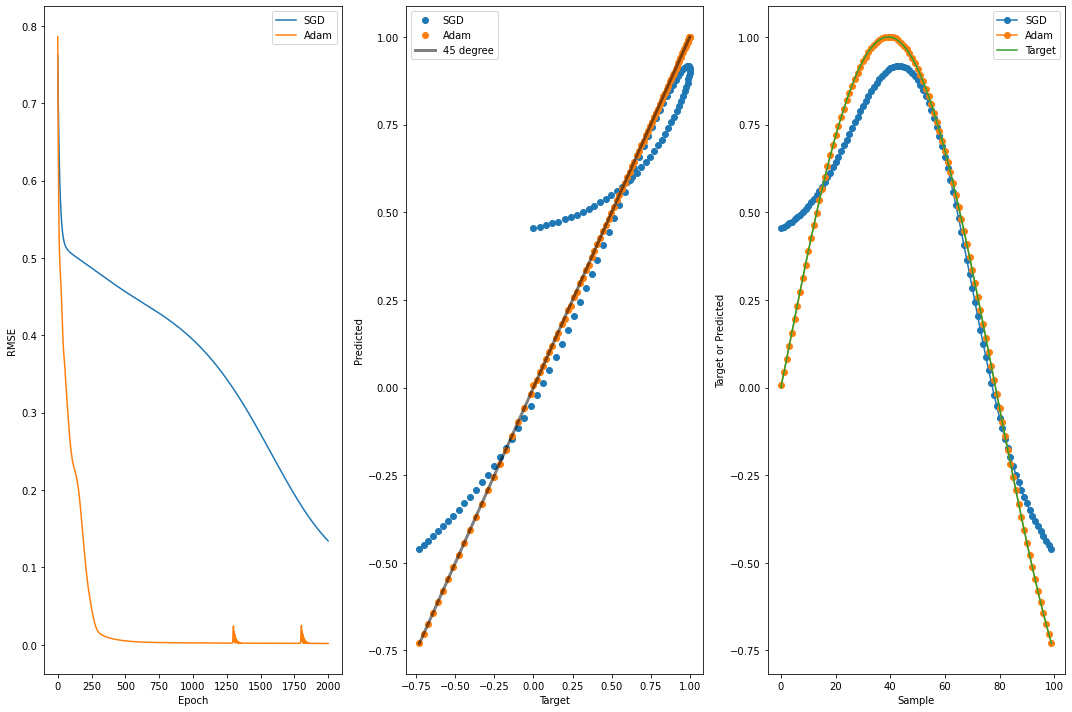

In [10]:
test_neuralnetwork()

## ReLU Activation Function

class NeuralNetwork():


    def __init__(self, n_inputs, n_hiddens_per_layer, n_outputs, activation_function="tanh"):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs

        # Set self.n_hiddens_per_layer to [] if argument is 0, [], or [0]
        if n_hiddens_per_layer == 0 or n_hiddens_per_layer == [] or n_hiddens_per_layer == [0]:
            self.n_hiddens_per_layer = []
        else:
            self.n_hiddens_per_layer = n_hiddens_per_layer

        # Initialize weights, by first building list of all weight matrix shapes.
        n_in = n_inputs
        shapes = []
        for nh in self.n_hiddens_per_layer:
            shapes.append((n_in + 1, nh))
            n_in = nh
        shapes.append((n_in + 1, n_outputs))

        # self.all_weights:  vector of all weights
        # self.Ws: list of weight matrices by layer
        self.all_weights, self.Ws = self.make_weights_and_views(shapes)

        # Define arrays to hold gradient values.
        # One array for each W array with same shape.
        self.all_gradients, self.dE_dWs = self.make_weights_and_views(shapes)

        self.trained = False
        self.total_epochs = 0
        self.error_trace = []
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None
        self.activation_function = activation_function

    def make_weights_and_views(self, shapes):
        # vector of all weights built by horizontally stacking flatenned matrices
        # for each layer initialized with uniformly-distributed values.
        all_weights = np.hstack([np.random.uniform(size=shape).flat / np.sqrt(shape[0])
                                 for shape in shapes])
        # Build list of views by reshaping corresponding elements from vector of all weights
        # into correct shape for each layer.
        views = []
        start = 0
        for shape in shapes:
            size =shape[0] * shape[1]
            views.append(all_weights[start:start + size].reshape(shape))
            start += size
        return all_weights, views


    # Return string that shows how the constructor was called
    def __repr__(self):
        return f'NeuralNetwork({self.n_inputs}, {self.n_hiddens_per_layer}, {self.n_outputs})'


    # Return string that is more informative to the user about the state of this neural network.
    def __str__(self):
        if self.trained:
            return self.__repr__() + f' trained for {self.total_epochs} epochs, final training error {self.error_trace[-1]}'


    def train(self, X, T, n_epochs, learning_rate, method='sgd'):

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing
            self.Tmeans = T.mean(axis=0)
            self.Tstds = T.std(axis=0)
            
        # Standardize X and T
        X = (X - self.Xmeans) / self.Xstds
        T = (T - self.Tmeans) / self.Tstds

        # Instantiate Optimizers object by giving it vector of all weights
        optimizer = Optimizers(self.all_weights)

        # Define function to convert value from error_f into error in original T units.
        error_convert_f = lambda err: (np.sqrt(err) * self.Tstds)[0] # to scalar

        if method == 'sgd':

            error_trace = optimizer.sgd(self.error_f, self.gradient_f,
                                        fargs=[X, T], n_epochs=n_epochs,
                                        learning_rate=learning_rate,
                                        error_convert_f=error_convert_f)

        elif method == 'adam':

            error_trace = optimizer.adam(self.error_f, self.gradient_f,
                                         fargs=[X, T], n_epochs=n_epochs,
                                         learning_rate=learning_rate,
                                         error_convert_f=error_convert_f)

        else:
            raise Exception("method must be 'sgd' or 'adam'")
        
        self.error_trace = error_trace

        # Return neural network object to allow applying other methods after training.
        #  Example:    Y = nnet.train(X, T, 100, 0.01).use(X)
        return self

   
    def relu(self, s):
        '''S is n_samples x n_units'''
        Y = S.copy()
        Y[Y < 0] = 0
        return Y

    def grad_relu(self, s):
        '''S is n_samples x n_units'''
        dY = s.copy()
        return (dY > 0).astype(int)
   
   
    def forward_pass(self, X):
        '''X assumed already standardized. Output returned as standardized.'''
        self.Ys = [X]
        for W in self.Ws[:-1]:
            
            
            if self.activation_function == 'tanh':
                self.Ys.append(np.tanh(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
                
            if self.activation_function == 'relu':
                self.Ys.append(self.relu(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
                      
                
        last_W = self.Ws[-1]
        self.Ys.append(self.Ys[-1] @ last_W[1:, :] + last_W[0:1, :])
        return self.Ys

    # Function to be minimized by optimizer method, mean squared error
    def error_f(self, X, T):
        Ys = self.forward_pass(X)
        mean_sq_error = np.mean((T - Ys[-1]) ** 2)
        return mean_sq_error

    # Gradient of function to be minimized for use by optimizer method
    def gradient_f(self, X, T):
        '''Assumes forward_pass just called with layer outputs in self.Ys.'''
        error = T - self.Ys[-1]
        n_samples = X.shape[0]
        n_outputs = T.shape[1]
        delta = - error / (n_samples * n_outputs)
        n_layers = len(self.n_hiddens_per_layer) + 1
        # Step backwards through the layers to back-propagate the error (delta)
        for layeri in range(n_layers - 1, -1, -1):
            # gradient of all but bias weights
            self.dE_dWs[layeri][1:, :] = self.Ys[layeri].T @ delta
            # gradient of just the bias weights
            self.dE_dWs[layeri][0:1, :] = np.sum(delta, 0)
           
           
            # Back-propagate this layer's delta to previous layer
            
            if self.activation_function == 'tanh':
                delta = delta @ self.Ws[layeri][1:, :].T * (1 - self.Ys[layeri] ** 2)
            
            if self.activation_function == 'relu':
                delta = delta @ self.Ws[layeri][1:, :].T * (self.grad_relu(self.Ys[layeri]))
            
            
        return self.all_gradients

    def use(self, X):
        X = (X - self.Xmeans) / self.Xstds
        Y = self.forward_pass(X)
        T = Y[-1] * self.Tstds + self.Tmeans
        return T

## Now for the Experiments!

Now that your code is working, let's apply it to some interesting data.

Read in the `auto-mpg.data` that we have used in lectures.  Let's apply neural networks to predict `mpg` using various neural network architectures, numbers of epochs, and our two activation functions.

This time we will partition the data into five parts after randomly rearranging the samples.  We will assign the first partition as the validation set, the second one as the test set, and the remaining parts will be vertically stacked to form the training set, as discussed in lecture.  We can use the RMSE on the validation set to pick the best values of the number of epochs and the network architecture.  Then to report on the RMSE we expect on new data, we will report the test set RMSE.

Read in the `auto-mpg.data` using `pandas` and remove all samples that contain missing values.  You should end up with 392 samples.

Now randomly reorder the samples.  First run `np.random.seed(42)` to guarantee that we all use the same random ordering of samples.

Partition the data into five folds, as shown in lecture.  To do this, complete the following function.

In [11]:
import pandas as pd
import numpy as np

'''    
    1. mpg:           continuous
    2. cylinders:     multi-valued discrete
    3. displacement:  continuous
    4. horsepower:    continuous
    5. weight:        continuous
    6. acceleration:  continuous
    7. model year:    multi-valued discrete
    8. origin:        multi-valued discrete
    9. car name:      string (unique for each instance)
'''


def partition(X, T, n_folds, random_shuffle=True):
    rows = np.arange(X.shape[0])
    
    if random_shuffle:
        np.random.shuffle(rows)
    
    X = X[rows, :]
    T = T[rows, :]
    n_samples = X.shape[0]
    n_per_fold = n_samples // n_folds # double-slash = "floor division" which rounds down to the nearest number
    n_last_fold = n_samples - n_per_fold * (n_folds - 1)  # handles case when n_samples not evenly divided by n_folds

    folds = []
    start = 0
    for foldi in range(n_folds-1):
        folds.append( (X[start:start + n_per_fold, :], T[start:start + n_per_fold, :]) )
        start += n_per_fold
    folds.append( (X[start:, :], T[start:, :]) )   # Changed in notes 07.2


    Xvalidate, Tvalidate = folds[0]
    Xtest, Ttest = folds[1]
    Xtrain, Ttrain = np.vstack([X for (X, _) in folds[2:]]), np.vstack([T for (_, T) in folds[2:]]) # what is this doing? Hint: look at [2:]
    
    return Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest


df = pd.read_csv('auto-mpg.data-original', delim_whitespace=True, na_values="NA", header=None)
df = df.dropna()

data = df.iloc[:, :-1].values # view everything except the car names (last column)
T = data[:, 0:1]  # data[:,0] results in a one-dimensional matrix, data[:,0:1] preserves its two-dimensional nature.
X = data[:, 1:] # give me the input variables

np.random.seed(42) # is this supposed to go here?

partition(X, T, 5)

names =  ['mpg','cylinders','displacement','horsepower','weight','acceleration','year','origin', 'model']
df.columns = names
Xnames = names[1:]
Tname = names[0]


Write a function named `run_experiment` that uses three nested for loops to try different values of the parameters `n_epochs`, `n_hidden_units_per_layer` and `activation_function` which will just be either `tanh` or `relu`. Don't forget to try `[0]` for one of the values of `n_hidden_units_per_layer` to include a linear model in your tests.  For each set of parameter values, create and train a neural network using the 'adam' optimization method and use the neural network on the training, validation and test sets.  Collect the parameter values and the RMSE for the training, validation, and test set in a list.  When your loops are done, construct a `pandas.DataFrame` from the list of results, for easy printing.  The first five lines might look like:

```
   epochs        nh    lr act func  RMSE Train  RMSE Val  RMSE Test
0    1000       [0]  0.01     tanh    3.356401  3.418705   3.116480
1    1000       [0]  0.01     relu    3.354528  3.428324   3.125064
2    1000      [20]  0.01     tanh    1.992509  2.355746   2.459506
3    1000      [20]  0.01     relu    2.448536  2.026954   2.581707
4    1000  [20, 20]  0.01     tanh    1.518916  2.468188   3.118376
```
Your function must return a `pandas.DataFrame` like this one.

Before starting the nested for loops, your `run_experiment` function must first call your `partition` function to form the training, validation and test sets.

An example call of your function would look like this:


This error belongs to:  1

Lowest RMSE Test For the Lowest RMSE Val:
   epochs    nh    lr act func  RMSE Train  RMSE Val  RMSE Test
9      50  [10]  0.01     relu    3.704646   3.23784   3.460306

This table belongs to:  1
    epochs         nh    lr act func  RMSE Train  RMSE Val  RMSE Test
0       10        [0]  0.01     tanh    8.852814  8.250057   8.024901
1       10        [0]  0.01     relu    6.122246  5.609655   5.446196
2       10       [10]  0.01     tanh    7.328928  6.705467   6.725384
3       10       [10]  0.01     relu    7.508540  6.783845   7.111280
4       10  [100, 10]  0.01     tanh    6.063218  5.716420   5.876064
5       10  [100, 10]  0.01     relu    8.113057  7.090870   7.236117
6       50        [0]  0.01     tanh    4.033396  4.058511   3.888245
7       50        [0]  0.01     relu    4.607567  4.694358   4.521078
8       50       [10]  0.01     tanh    3.657017  3.735936   2.939046
9       50       [10]  0.01     relu    3.704646  3.237840   3.460306
10   

"\nObservations:\n\n1. Throughout my expirements I noticed that relu seemed to do better than tanh when we had a large number of \nepochs. Let's say greter than 1,000 or 1,500. The reason I believe this occurs is due to many reasons. One, Tanh's \nderivative function does not produce volatile results as the absolute value of x gets larger. Because of this, \nwhen the weights get updated, the update isn't too large and does not miss the local optimum entirely. However, \nbecause of its controlled & clustered derivative values, tanh is subject to the vanishing gradient problem. \nThe vanishing gradient problem is when you have small derivative values. If these values are too close to 0 then\nno useful information can be backpropragated.  This is why relu performs better in particular circumstances. \nRelu is the solution the the vanishing gradient problem, so we can draw a correlation between tanh inadequate \nperformance and relu success.  Another reason why relu performs better in cert

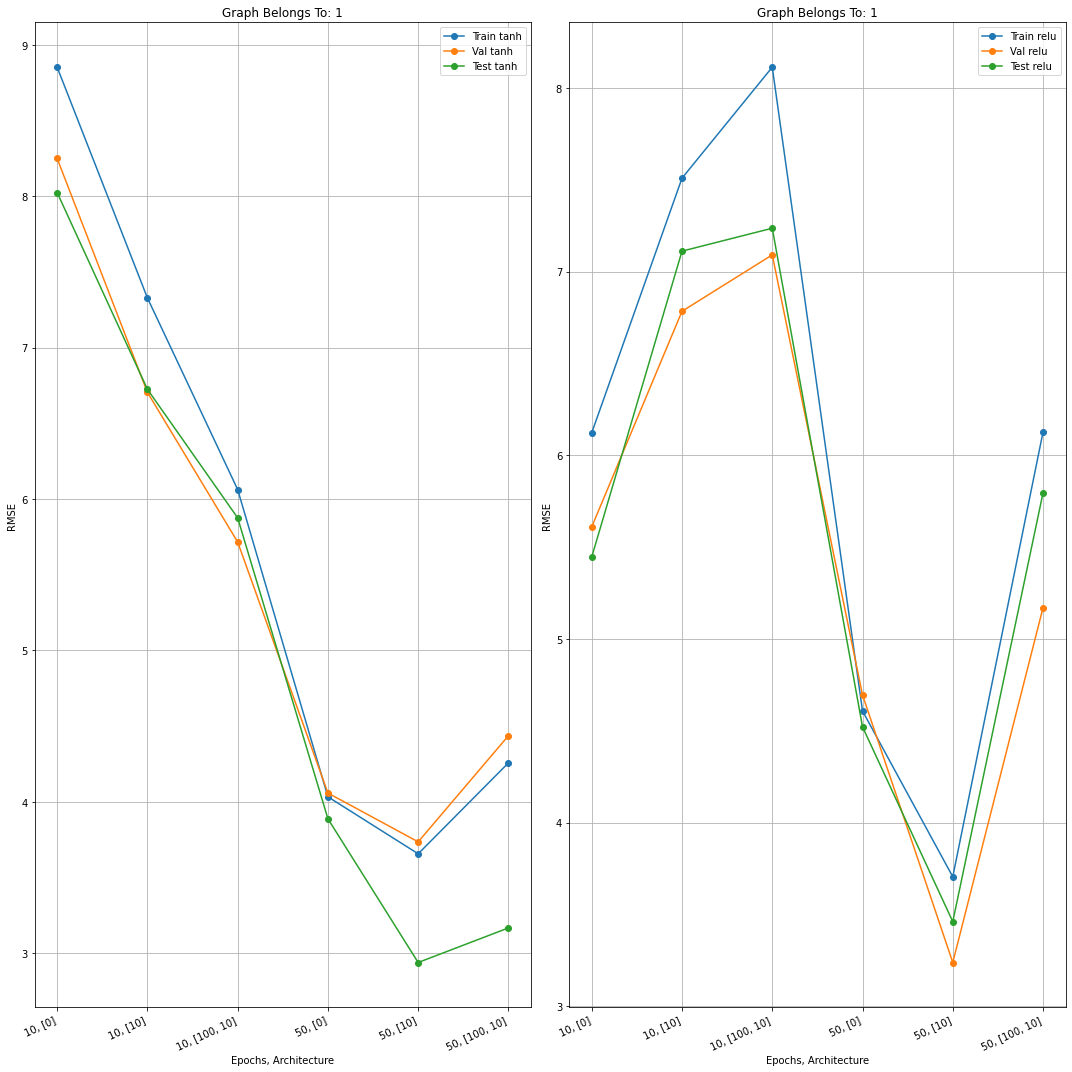

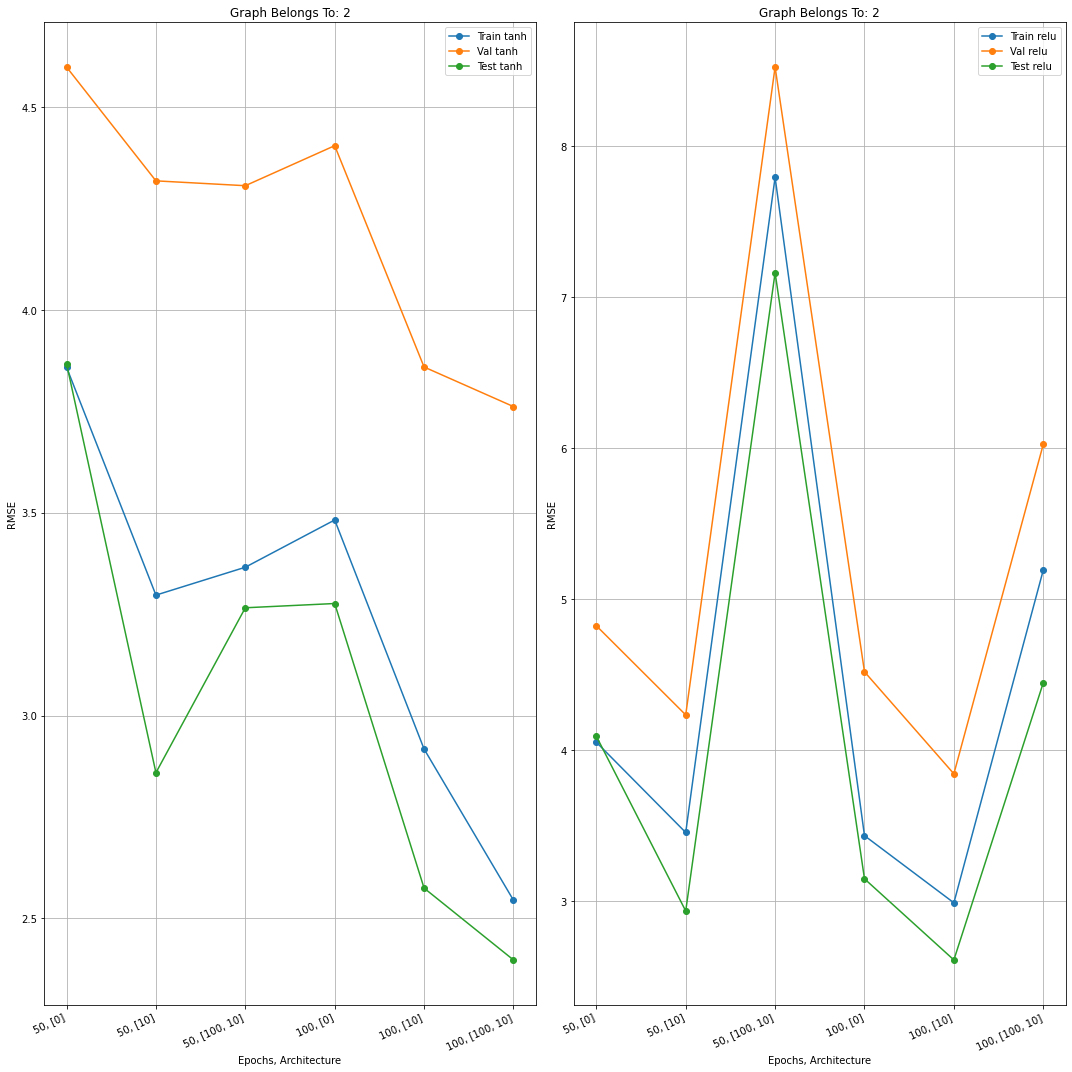

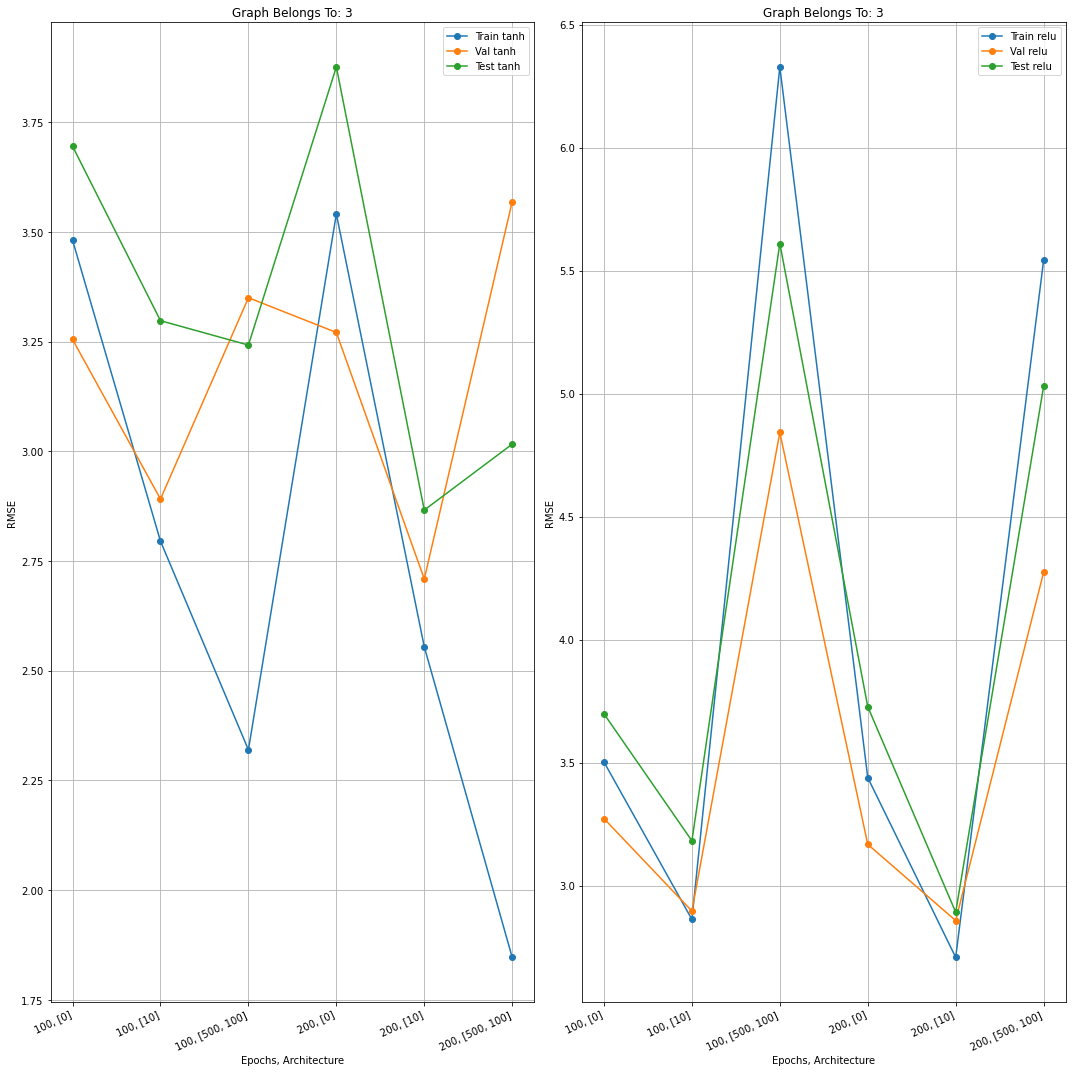

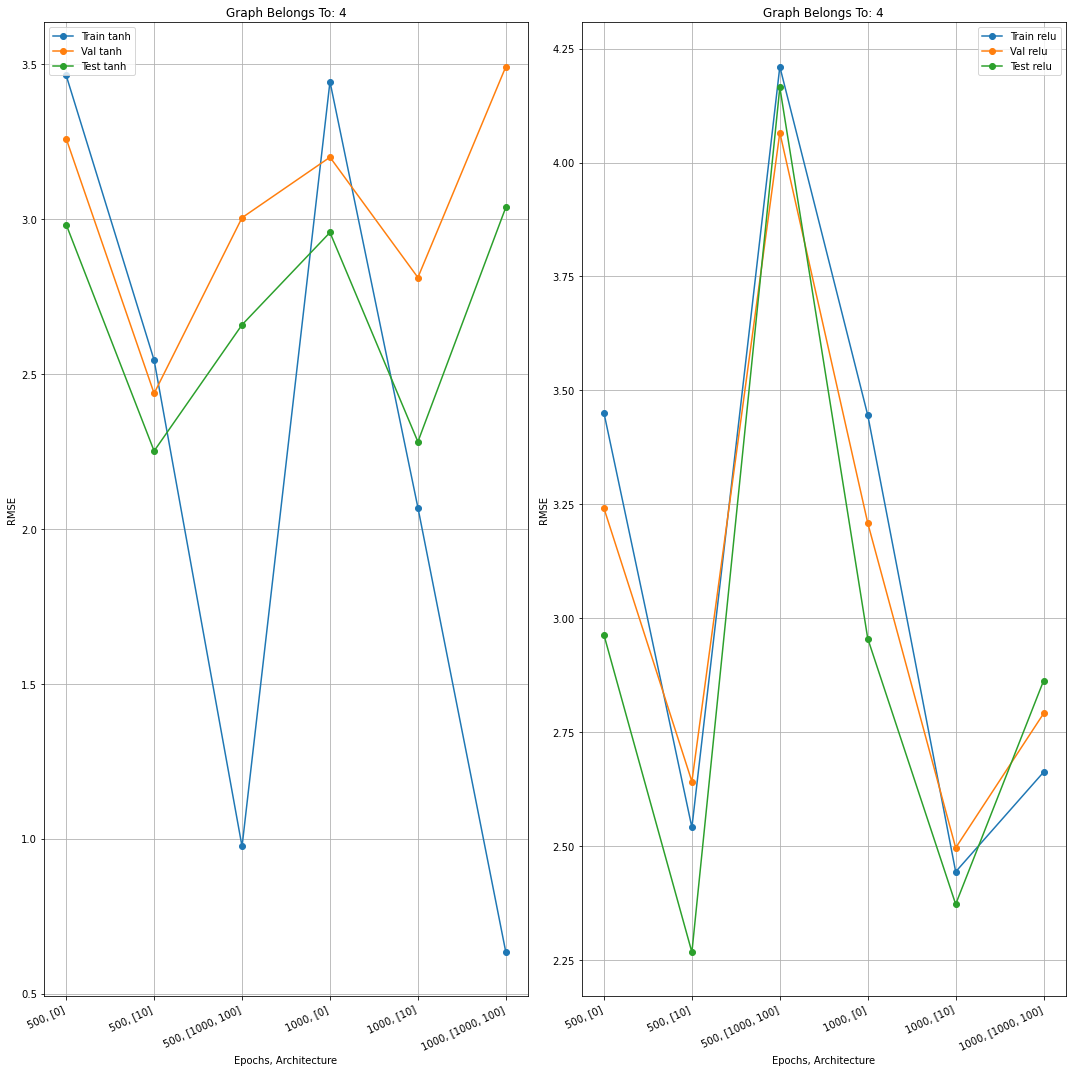

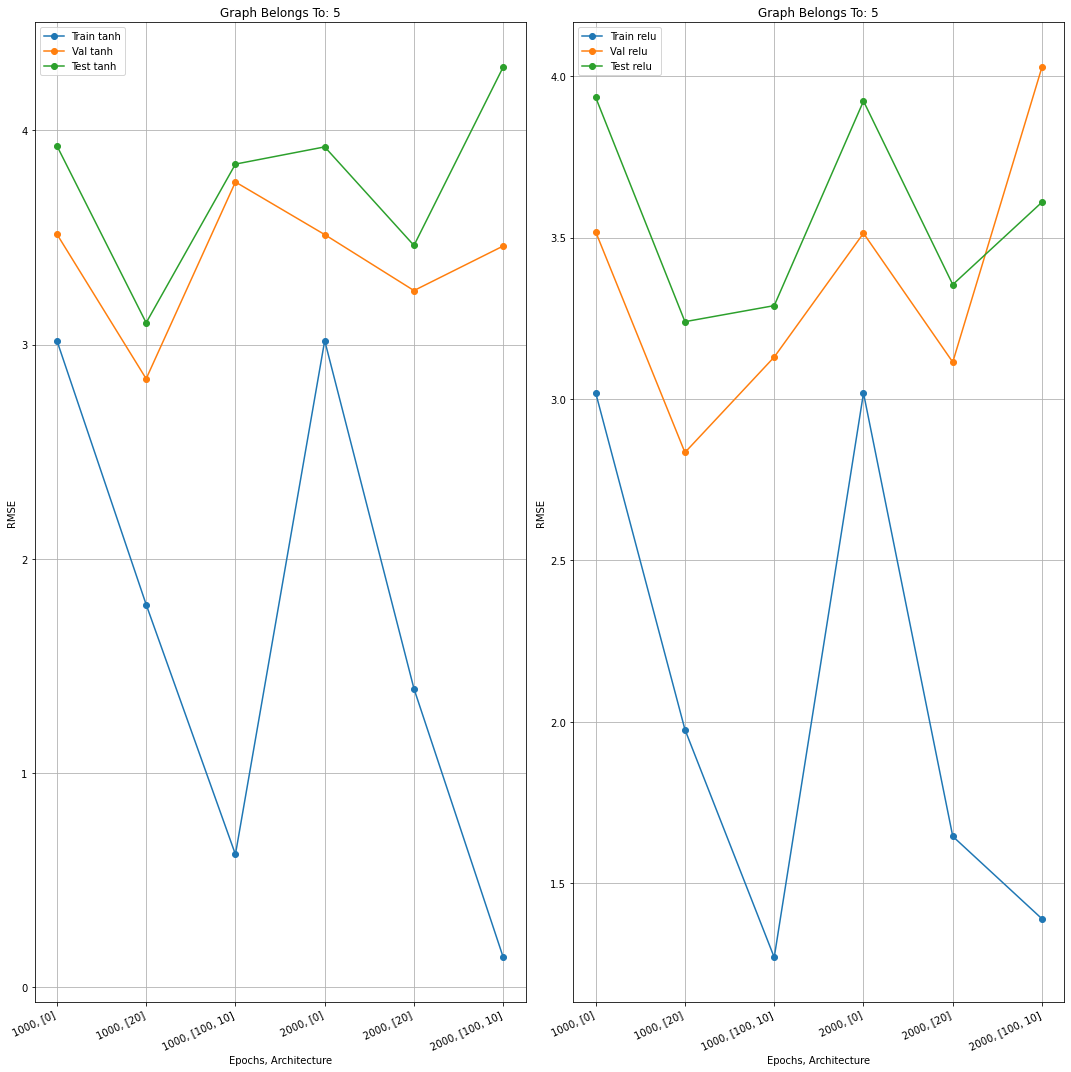

In [12]:
def rmse(A, B):
    return np.sqrt(np.mean((A - B)**2))

def run_experiment(X, T, n_folds, n_epochs_choices, n_hidden_units_per_layer_choices, activation_function_choices):
    Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest = partition(X, T, n_folds)
    results = []
    for rate in [0.01]: # learning rates
        for epochs in n_epochs_choices: # Training durations
            for nh in n_hidden_units_per_layer_choices: # Layer sizes
                for method in activation_function_choices: # Optimizers
                    # instantiate and train
                    nnet = NeuralNetwork(Xtrain.shape[1], nh, Ttrain.shape[1], activation_function=method)
                    nnet.train(Xtrain, Ttrain, epochs, rate, 'adam')
                    # append the results of each experiment
                    results.append([epochs, nh, rate, method,
                                    rmse(Ttrain, nnet.use(Xtrain)),
                                    rmse(Tvalidate, nnet.use(Xvalidate)),
                                    rmse(Ttest, nnet.use(Xtest))])
                    # load these into a dataframe and give it some column titles
                    df = pd.DataFrame(results, columns=('epochs', 'nh', 'lr', 'act func', 'RMSE Train',
                                                        'RMSE Val', 'RMSE Test'))    
    
    return df





# relu is better

for i in range(5):
    df = pd.read_csv('auto-mpg.data-original', delim_whitespace=True, na_values="NA", header=None)
    df = df.dropna()

    data = df.iloc[:, :-1].values # view everything except the car names (last column)
    T = data[:, 0:1]  # data[:,0] results in a one-dimensional matrix, data[:,0:1] preserves its two-dimensional nature.
    X = data[:, 1:] # give me the input variables

    np.random.seed(42)
    result_df = run_experiment(X, T, n_folds=5, 
                               n_epochs_choices=[10, 50],
                               n_hidden_units_per_layer_choices=[[0], [10], [100, 10]],
                               activation_function_choices=['tanh', 'relu'])
    
    if i == 1:
        np.random.seed(15)
        result_df = run_experiment(X, T, n_folds=5, 
                                   n_epochs_choices=[50, 100],
                                   n_hidden_units_per_layer_choices=[[0], [10], [100, 10]],
                                   activation_function_choices=['tanh', 'relu'])
        
    if i == 2:
        np.random.seed(97)
        result_df = run_experiment(X, T, n_folds=5, 
                                   n_epochs_choices=[100, 200],
                                   n_hidden_units_per_layer_choices=[[0], [10], [500, 100]],
                                   activation_function_choices=['tanh', 'relu'])
        
    if i == 3:
        np.random.seed(66)
        result_df = run_experiment(X, T, n_folds=5, 
                                   n_epochs_choices=[500, 1000],
                                   n_hidden_units_per_layer_choices=[[0], [10], [1000, 100]],
                                   activation_function_choices=['tanh', 'relu'])
        
    if i == 4:
        np.random.seed(81)
        result_df = run_experiment(X, T, n_folds=5, 
                                   n_epochs_choices=[1000, 2000],
                                   n_hidden_units_per_layer_choices=[[0], [20], [100, 10]],
                                   activation_function_choices=['tanh', 'relu'])
        


    Min = result_df.nsmallest(1, 'RMSE Val')
    print('\nThis error belongs to: ', str(i+1))
    print('\nLowest RMSE Test For the Lowest RMSE Val:')
    print(Min)

    plt.figure(figsize=(15, 15))

    # we'll plot two graphs of RMSE on the Y-axis vs. our training durations and architectures on the X-axis

    # plot results with SGD optmization on the left
    plt.subplot(1, 2, 1)
    dftanh = result_df[(result_df['act func'] == 'tanh')]
    xs = range(dftanh.shape[0])
    plt.plot(xs, dftanh[['RMSE Train', 'RMSE Val', 'RMSE Test']], 'o-')
    xticks = dftanh[['epochs', 'nh']].apply(lambda x: f'{x[0]}, {x[1]}', axis=1) # converting to strings
    plt.xticks(range(len(xticks)), xticks, rotation=25, ha='right')
    plt.xlabel('Epochs, Architecture')
    # plt.ylim(0, 7)
    plt.ylabel('RMSE')
    plt.legend(('Train tanh', 'Val tanh', 'Test tanh'))
    title = 'Graph Belongs To: ' + str(i+1)
    plt.title(title)
    plt.grid('on')

    # plot results with Adam optimization on the right
    plt.subplot(1, 2, 2)
    dfrelu = result_df[(result_df['act func'] == 'relu')]
    xs = range(dfrelu.shape[0])
    plt.plot(xs, dfrelu[['RMSE Train', 'RMSE Val', 'RMSE Test']], 'o-')
    xticks = dfrelu[['epochs', 'nh']].apply(lambda x: f'{x[0]}, {x[1]}', axis=1)
    plt.xticks(range(len(xticks)), xticks, rotation=25, ha='right')
    plt.xlabel('Epochs, Architecture')
    # plt.ylim(0, 8)
    plt.ylabel('RMSE')
    plt.legend(('Train relu', 'Val relu', 'Test relu'))
    plt.title(title)
    plt.grid('on')

    plt.tight_layout();
    print('\nThis table belongs to: ', str(i+1))
    print(result_df)
    print()
    
'''
Observations:

1. Throughout my expirements I noticed that relu seemed to do better than tanh when we had a large number of 
epochs. Let's say greter than 1,000 or 1,500. The reason I believe this occurs is due to many reasons. One, Tanh's 
derivative function does not produce volatile results as the absolute value of x gets larger. Because of this, 
when the weights get updated, the update isn't too large and does not miss the local optimum entirely. However, 
because of its controlled & clustered derivative values, tanh is subject to the vanishing gradient problem. 
The vanishing gradient problem is when you have small derivative values. If these values are too close to 0 then
no useful information can be backpropragated.  This is why relu performs better in particular circumstances. 
Relu is the solution the the vanishing gradient problem, so we can draw a correlation between tanh inadequate 
performance and relu success.  Another reason why relu performs better in certain scenarios is because it is 
more computationally efficient than tanh. So as the number of epochs increases significantly, relu can take and 
benefit tremendously. This is because relu does better in large quantities. Observation #3 elaborates more on this 
point.

2. The best RMSE test value I encoutered came from tanh. Here are the details:

    Lowest RMSE Test For the Lowest RMSE Val:
       epochs    nh    lr act func  RMSE Train  RMSE Val  RMSE Test
    2     500  [10]  0.01     tanh    2.544817  2.437591   2.251647
    
    The surprising thing here is that the number of epochs is low. At only 500.  Also, in this run, it only had 
    to use one hidden layer! To a casual observer it would seem that there wouldn't be much quality learning 
    going on from any function because of the low hyperparameters. This is not the case. With the data we have
    managed to acccumulate, tanh prospers when the number of epochs is relatively low. This is because Tanh's 
    dereivative function has the ability to not deviate from the pack to produce massive outliers. It plots its
    points with precision and very close to the pack. This is because tanh is a complex function compared to relu.
    In my expirements, with a low number of epochs, tanh is less susciptible to the vanishing gradient problem.
    Also, in my expirements when the number of epochs was 500 or less tanh, nearly every time came out on top.
    This is because of reasons already mentioned. The biggest reason is that relu relies heavily on large 
    quatities of relu plots to produce accurate results. Observatin #3 elaborates more on this point.

3. A third obeservation is that relu and tanh did not heavily depend on two hidden layers to produce its
optimum RMSE values. A fourth observation, is that tanh did better with less information tahn relu. When things 
seemed random tanh was better. This means that in real world scenarios where things don't line up very well, 
tanh prospers and can find order in the chaos by beautifully bending the curve. Tanh is more complex while relu 
is a simple piecewise function. Tanh can very nicely map the curve when there seems to be no order in the data and 
the hyperparameters passed. Relu just selects a point to bend the linear line. Although don't underestimate its 
simplicity.  Relu's real strength is in numbers. The bends of all relus' can line up along the curve, creating a
great prediction at a computationally effective cost. Simple but effective in large quantites. However when things 
are random and chaotic, tanh with the correct hyperparameters can outshine relu. Relu is brute force, tanh is more
elegant. But don't underestimate the vanishing gradient problem for it can be the demise of tanh.

'''

Find the lowest value of `RMSE Val` in your table and report the `RMSE Test` and the parameter values that produced this.  This is your expected error in predicted miles per gallon.  Discuss how good this prediction is.

Plot the RMSE values for training, validation and test sets versus the combined parameter values of number of epochs and network architecture.  Make one plot for `tanh` as the activation function and a second one for `relu`. 

Describe at least three different observations you make about these plots.  What do you find interesting?

1. ...
2. ...
3. ...

## Grading and Check-in

You and your partner will score of 70 points if your functions are defined correctly. You can test this grading process yourself by downloading [A2grader.zip](https://www.cs.colostate.edu/~cs445/notebooks/A2grader.zip) and extract `A2grader.py` parallel to this notebook.  We recommend keeping this notebook and the grader script in a dedicated folder with *just those two files.* Run the code in the in the following cell to see an example grading run.  If your functions are defined correctly, you should see a score of 70/70.  The remaining 30 points will be based on 1) other testing and the results you obtain, and 2) your discussions.

In [13]:
%run -i A2grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Infantes-A2.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing
  w = np.array([0.0])
  def cubic(wmin):
      return (w[0] - wmin) ** 3 + (w[0] - wmin) ** 2
  def grad_cubic(wmin):
      return 3 * (w[0] - wmin) ** 2 + 2 * (w[0] - wmin)
  wmin = 0.5
  opt = Optimizers(w)
  errors_sgd = opt.sgd(cubic, grad_cubic, [wmin], 100, 0.01)

sgd: Epoch 10 Error=0.11889
sgd: Epoch 20 Error=0.11092
sgd: Epoch 30 Error=0.10176
sgd: Epoch 40 Error=0.09162
sgd: Epoch 50 Error=0.08081
sgd: Epoch 60 Error=0.06972
sgd: Epoch 70 Error=0.05879
sgd: Epoch 80 Error=0.04844
sgd: Epoch 90 Error=0.03901
sgd: Epoch 100 Error=0.03072

--- 10/10 points. Returned correct value.

Testing
  w = np.array([0.0])
  def cubic(wmin):
      return (w[0] - wmin) ** 3 + (w[0] - wmin) ** 2
  def grad_cubic(wmin):
      return 3 * (w[0] - wmi

Name this notebook as `Lastname1-Lastname2-A2.ipynb`| with Lastname1 being then name of the last name of the person who is turning in the notebook.

A different but similar grading script will be used to grade your checked-in notebook.  It will include different tests.

## Extra Credit: 5 point

Add the Swish activation function as a third choice in your `train` function in your `NeuralNetwork` class.
A little googling will find definitions of it and its gradient.  Start with [this article](https://www.machinecurve.com/index.php/2019/05/30/why-swish-could-perform-better-than-relu/#todays-activation-functions).

Use your `run_experiment` function to compare results for all three activation functions.  Discuss the results.